# Python-in-the-lab: functions and data fitting

In [1]:
import os
import numpy as np
import scipy.integrate as integrate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
mainDir = "/home/gf/src/Python/Python-in-the-lab/Bk"
# Today we use the same file of the shapes
filename = "F64ac_0.02_time_V_T.dat"
filename = os.path.join(mainDir, filename)
data = np.loadtxt(filename, comments="#")
time = data[:,0]
with open(filename) as f:
    header = f.readline()
sizes = [float(size) for size in header.split()[1:]]
shapes = dict()
for i, size in enumerate(sizes):
    shapes[size] = data[:,i+1]

## Next Problems
## 1. Make the average of the 8 normalized curves (You can do it)

### Try to solve the problem above by yourself. Anyway, a possible solution is found below

In [5]:
# Get the average of the 8 curves
#average = np.zeros_like(shapes[size]) # Ahah, this is not required!
average = 0
for size in shapes:
    shape = shapes[size]
    average += shape/integrate.trapz(shape,time)
average /= len(shapes)
type(average) == type(shapes[size])

True

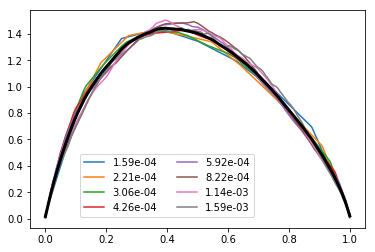

In [6]:
# Replot for comparison with the average
for size in sorted(shapes):
    lb = "{0:.2e}".format(size)
    shape = shapes[size]
    norm = integrate.trapz(shapes[size], time)
    plt.plot(time, shapes[size]/norm, label=lb)
plt.legend(ncol=2,loc=(0.15,.05))
plt.plot(time, average, 'k', lw=3);

## 2. Make a fit of the average curve with 
## $[x(1-x)]^{\gamma -1} * exp(-Ax)$, 

## with $A, \gamma$ as fitting parameters. (You can do it. Look for curve_fit)

In [7]:
# Introduction to functions and fitting function
parameters = ["gamma", "A1", "A2"]
def fitShape(x, gamma, a1, a2):
    """
    fitting function for the average shape
    
    Parameters:
    ===========
    a1: float
        amplitude
    a2: float
        constant of the exponential
    gamma: float
        exponent of the shape
    """
    return a1*(x*(1-x))**(gamma-1) * np.exp(-a2*x)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitShape, time, average)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.3f} +/- {2:.3f}".format(parameter, p, diag**0.5))
#pcov.diagonal()**0.5 # These are the errors of the fitting parameters at 1 sigma

Parameter gamma = 1.802 +/- 0.002
Parameter A1 = 5.613 +/- 0.017
Parameter A2 = 0.549 +/- 0.002


## Hold on! I guess there are too many parameters... 

### Yes, the average should have an integral equal to 1, or not?

#### Let's check it

In [8]:
integrate.trapz(average, time)

1.0

## Ahah.. so? How do we change the fitting function?

In [9]:
# Introduction to functions and fitting function
parameters = ["gamma", "A"]
def fitShape(x, gamma, a):
    """
    fitting function for the average shape
    
    Parameters:
    ===========
    a: float
        constant of the exponential
    gamma: float
        exponent of the shape
    """
    f = (x*(1-x))**(gamma-1) * np.exp(-a * x)
    norm = integrate.trapz(f, x)
    return f/norm

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitShape, time, average)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.3f} +/- {2:.3f}".format(parameter, p, diag**0.5))
#pcov.diagonal()**0.5 # These are the errors of the fitting parameters at 1 sigma

Parameter gamma = 1.802 +/- 0.001
Parameter A = 0.549 +/- 0.002


Text(0, 0.5, 'average shape (normalized)')

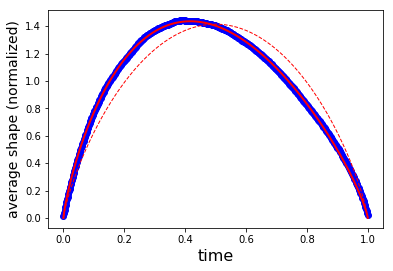

In [10]:
plt.plot(time, average, 'bo')
plt.plot(time, fitShape(time, *popt), '-r', lw=2) # Note the use of *popt
plt.plot(time, fitShape(time, popt[0], 0), '--r', lw=1) # What did I do?
plt.xlabel("time", size=16)
plt.ylabel("average shape (normalized)", size=14)

# Fitting is so important in the lab... let's explore it a little bit

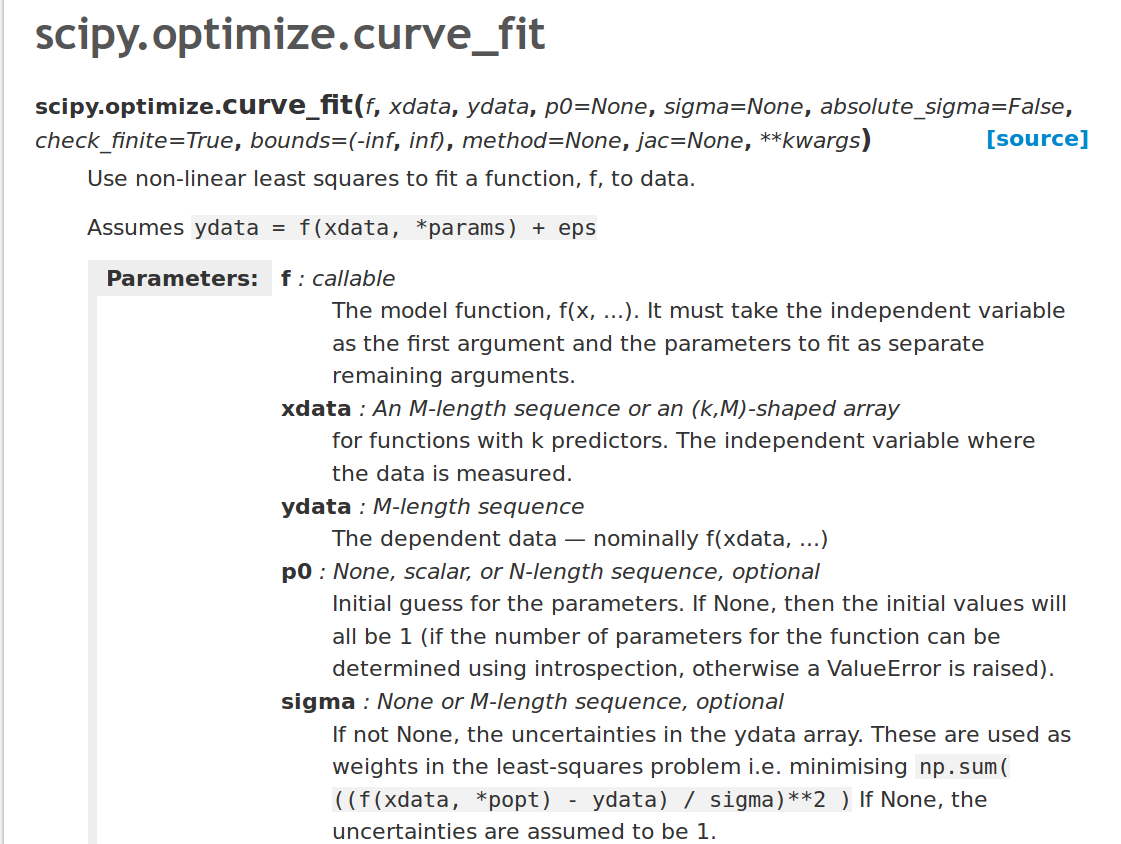

In [11]:
from IPython.display import Image
imageDir = "/home/gf/src/Python/Python-in-the-lab/images"
Image(filename=os.path.join(imageDir,'curve_fit1.png'))

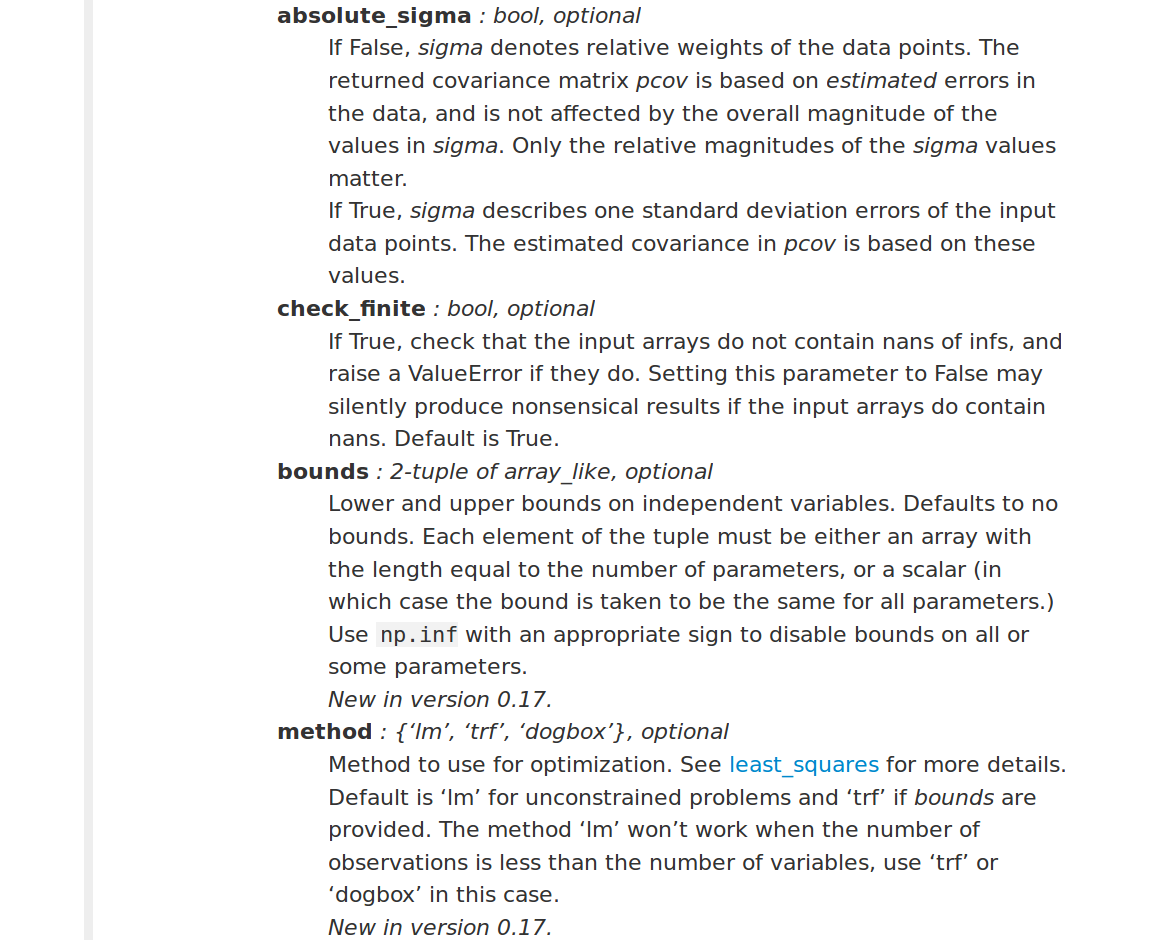

In [12]:
Image(filename=os.path.join(imageDir,'curve_fit2.png'))

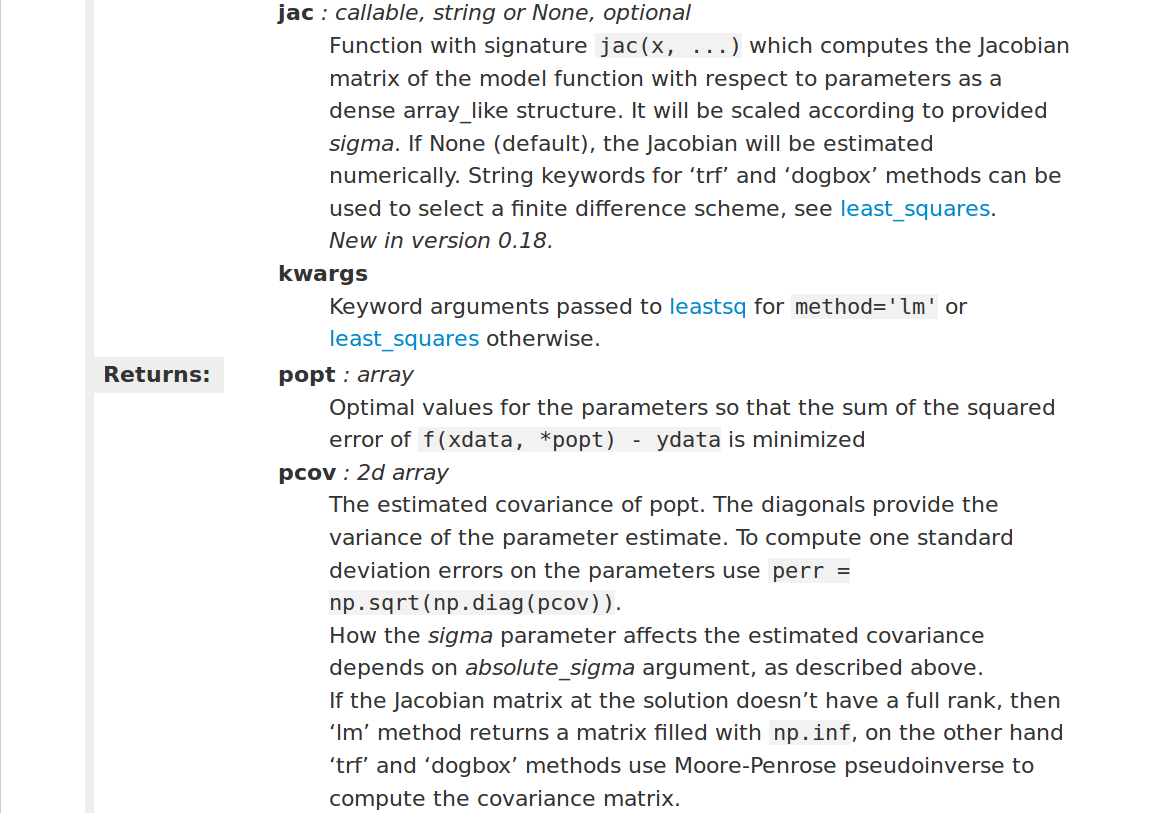

In [13]:
Image(filename=os.path.join(imageDir,'curve_fit3.png'))

# Ok, man, this is a serious problem

I am doing an average over 8 curves, I think I can estimate an error bar for each point, can I?

But then should I use it for doing what? Weight or error? And...

*Does the fitting parameters and their errors depend on this choice???*

### Problem: calculate the error bars, and use them in the fitting fuction. Show if the fitting parameters change and their error

_Reminder: the variance of the average is the variance of the data over the number of data_
$\sigma^2_\bar{x} = \sigma_x^2/N$

Parameter gamma = 1.8196 +/- 0.0021
Parameter A = 0.5216 +/- 0.0047
Parameter gamma = 1.8196 +/- 0.0014
Parameter A = 0.5216 +/- 0.0032


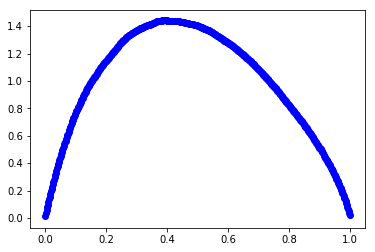

In [14]:
# The solution goes here...
rows, cols = data.shape
variances = np.array([np.var(row) for row in data[:,1:]])
err_average = (variances / (cols - 1))**0.5
popt1, pcov1 = curve_fit(fitShape, time, average, p0=(1.6,0.5), sigma=err_average)
for p, diag, parameter in zip(popt1,pcov1.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))
plt.plot(time, average, 'bo')
plt.plot(time, fitShape(time, *popt), '-b', lw=2) # Note the use of *popt
popt2, pcov2 = curve_fit(fitShape, time, average, p0=(1.6,0.5), sigma=err_average, absolute_sigma=True)
for p, diag, parameter in zip(popt2,pcov2.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))

**Oh, we did an error: we calculated the variances over the original data, not on the normalized shapes.**

**How can we solve this problem?
We can redo the calculus adding the normalization, but it is better to define a normalized set of data**


<ErrorbarContainer object of 3 artists>

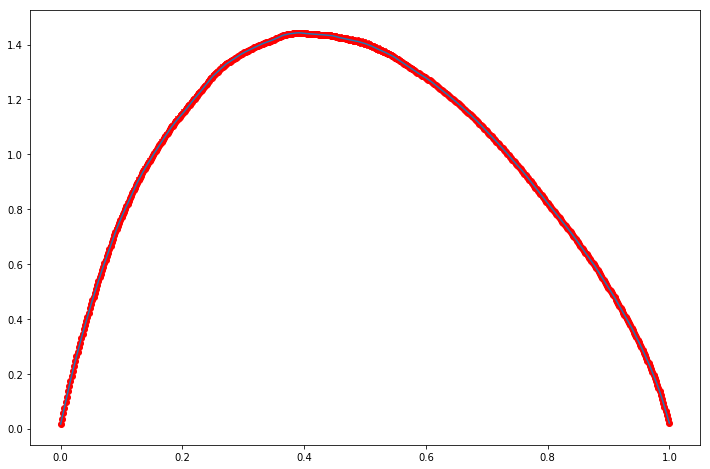

In [15]:
def my_int(y, t=time):
    return integrate.trapz(y, t)

fig = plt.figure(figsize=(12,8))
norms = np.apply_along_axis(my_int, 0, data[:,1:])
data_norm = data[:,1:] / norms
average1 = np.apply_along_axis(np.mean, 1, data_norm)

plt.plot(time, average, 'b') # The old calculus
plt.plot(time, average1, 'ro') # The new one

# Can we calculate the sigmas (error bars) in the same way?
rows, cols = data_norm.shape
sigmas = (np.apply_along_axis(np.var, 1, data_norm)/cols)**0.5
plt.errorbar(time, average1, sigmas, fmt="", ecolor='r')

In [16]:
print("No weights")
popt, pcov = curve_fit(fitShape, time, average)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))
print(35*"*")
print("Just weights")
popt, pcov = curve_fit(fitShape, time, average, sigma=err_average)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))
print(35*"*")
print("Weights and error bars")
popt, pcov = curve_fit(fitShape, time, average, sigma=err_average, absolute_sigma=True)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))

No weights
Parameter gamma = 1.8018 +/- 0.0015
Parameter A = 0.5487 +/- 0.0024
***********************************
Just weights
Parameter gamma = 1.8196 +/- 0.0021
Parameter A = 0.5216 +/- 0.0047
***********************************
Weights and error bars
Parameter gamma = 1.8196 +/- 0.0014
Parameter A = 0.5216 +/- 0.0032


In [17]:
popt1, pcov1 = curve_fit(fitShape, time, average, p0=(1.6,0.5), sigma=sigmas) # See the problem?

In [18]:
popt1

array([1.81810857, 0.53193904])

In [19]:
# Explore the function
print(fitShape.__doc__)


    fitting function for the average shape
    
    Parameters:
    a: float
        constant of the exponential
    gamma: float
        exponent of the shape
    


In [20]:
# Can we make a running code out of the notebook? Let's do it!

In [21]:
fitShape.__name__

'fitShape'